In [1]:
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('../')

import tensorflow as tf
import numpy as np
import gc
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc

from models.neural_network import NeuralNetwork
from models.fcc import FCC
from models.util import *


os.environ["CUDA_VISIBLE_DEVICES"] = "2"

#Seed used for all calculations of training and test point indices 
SEED = 17

Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (545333)
num_classes = 2
eps = 10

In [3]:
#Load model from disk (Note: Drebin takes a few minutes to load the dataset)
model_name = 'DREBIN'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = FCC(model_name=model_name, dataset='drebin', seed=SEED)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 10
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)   

Total Model Params: 34918082
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.test_data, model.test_labels)[1]))

3913/3913 [==============================] - 15s 4ms/step
Model Accuracy: 0.98722


In [5]:
#Get training samples
num_train_samples = 100
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [6]:
num_test_samples_per_class = 50
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
fgsm_data = model.generate_perturbed_data_binary(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM')
bim_a_data = model.generate_perturbed_data_binary(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-A', iterations=eps)
bim_b_data = model.generate_perturbed_data_binary(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM-B', iterations=eps)
#For JSMA we need to flip labels
jsma_tar = (model.test_labels[test_indices] == 0).astype(int)
jsma_data = model.generate_perturbed_data_binary(model.test_data[test_indices], jsma_tar,seed=SEED, perturbation='JSMA', iterations=eps)

In [7]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()
del model
gc.collect()
#Reload the model and weights
model = FCC(model_name=model_name, dataset='drebin', seed=SEED)
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


In [8]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-A: %.5f' % (model.model.evaluate(bim_a_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM-B: %.5f' % (model.model.evaluate(bim_b_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy JSMA: %.5f' % (model.model.evaluate(jsma_data,model.test_labels[test_indices])[1]))

100/100 [==============================] - 0s 5ms/step
Model Accuracy REG: 0.91000
100/100 [==============================] - 0s 4ms/step
Model Accuracy FGSM: 0.50000
100/100 [==============================] - 0s 4ms/step
Model Accuracy BIM-A: 0.00000
100/100 [==============================] - 0s 4ms/step
Model Accuracy BIM-B: 0.25000
100/100 [==============================] - 0s 4ms/step
Model Accuracy JSMA: 0.00000


In [9]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,input_shape))
bim_a_preds = model.model.predict(bim_a_data.reshape(-1,input_shape))
bim_b_preds = model.model.predict(bim_b_data.reshape(-1,input_shape))
jsma_preds = model.model.predict(jsma_data.reshape(-1,input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_a_labels = preds_to_labels(bim_a_preds)
bim_b_labels = preds_to_labels(bim_b_preds)
jsma_labels = preds_to_labels(jsma_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
fgsm_idx = np.where(np.argmax(fgsm_preds, axis=1) != true_preds)[0]
bim_a_idx = np.where(np.argmax(bim_a_preds, axis=1) != true_preds)[0]
bim_b_idx = np.where(np.argmax(bim_b_preds, axis=1) != true_preds)[0]
jsma_idx = np.where(np.argmax(jsma_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
fgsm_data_fil = fgsm_data[fgsm_idx]
bim_a_data_fil = bim_a_data[bim_a_idx]
bim_b_data_fil = bim_b_data[bim_b_idx]
jsma_data_fil = jsma_data[jsma_idx]


#Filter labels to be used
fgsm_labels_fil = fgsm_labels[fgsm_idx]
bim_a_labels_fil = bim_a_labels[bim_a_idx]
bim_b_labels_fil = bim_b_labels[bim_b_idx]
jsma_labels_fil = jsma_labels[jsma_idx]

In [10]:
#Get distortion 
print ('FGSM: %.5f' % (avg_l2_dist(reg_data[fgsm_idx], fgsm_data_fil)))
print ('BIM-A: %.5f' % (avg_l2_dist(reg_data[bim_a_idx], bim_a_data_fil)))
print ('BIM-B: %.5f' % (avg_l2_dist(reg_data[bim_b_idx], bim_b_data_fil)))
print ('JSMA: %.5f' % (avg_l2_dist(reg_data[jsma_idx], jsma_data_fil)))

FGSM: 615.04098
BIM-A: 1.00000
BIM-B: 2.40988
JSMA: 1.33507


In [11]:
#Get cosine similarity and norms
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)
grads_train = normalize(grads_train)
grads_reg_norms, cos_sim_reg = norms_and_cos(model, reg_data, reg_labels, grads_train)
grads_fgsm_norms, cos_sim_fgsm =norms_and_cos(model, fgsm_data_fil, fgsm_labels_fil, grads_train)
grads_bim_a_norms, cos_sim_bim_a = norms_and_cos(model, bim_a_data_fil, bim_a_labels_fil, grads_train)
grads_bim_b_norms , cos_sim_bim_b= norms_and_cos(model, bim_b_data_fil, bim_b_labels_fil, grads_train)
grads_jsma_norms, cos_sim_jsma = norms_and_cos(model, jsma_data_fil, jsma_labels_fil, grads_train)

../models/util.py:81: RuntimeWarning: invalid value encountered in sqrt
  norms = np.sqrt(np.dot(grads, grads.T)).diagonal()


**LOGISTIC REGRESSION FOR GREYBOX**

In [12]:
#Train a logistic regression classifier on the data. We only train on gray box attack points. 
#Due to lack of data (computationally expensive to compute attack points), we use 95% of data to train and 5% to test

#Select training and test indices
np.random.seed(SEED)
train_pct = .95
reg_train_idx = np.random.choice(np.arange(num_test_samples), int(train_pct*num_test_samples), replace=False)
reg_test_idx = get_test_from_train_idx(np.arange(num_test_samples), reg_train_idx)
fgsm_train_idx = np.random.choice(np.arange(len(fgsm_idx)), int(len(fgsm_idx)*train_pct), replace=False)
fgsm_test_idx = get_test_from_train_idx(np.arange(len(fgsm_idx)), fgsm_train_idx)
bim_a_train_idx = np.random.choice(np.arange(len(bim_a_idx)), int(len(bim_a_idx)*train_pct), replace=False)
bim_a_test_idx = get_test_from_train_idx(np.arange(len(bim_a_idx)), bim_a_train_idx)
bim_b_train_idx =np.random.choice(np.arange(len(bim_b_idx)), int(len(bim_b_idx)*train_pct), replace=False)
bim_b_test_idx = get_test_from_train_idx(np.arange(len(bim_b_idx)), bim_b_train_idx)
jsma_train_idx =np.random.choice(np.arange(len(jsma_idx)), int(len(jsma_idx)*train_pct), replace=False)
jsma_test_idx = get_test_from_train_idx(np.arange(len(jsma_idx)), jsma_train_idx)

# Set up training and test data for logistic regression
train_data = np.concatenate((cos_sim_reg[reg_train_idx], 
                             cos_sim_fgsm[fgsm_train_idx],
                             cos_sim_bim_a[bim_a_train_idx],
                             cos_sim_bim_b[bim_b_train_idx], 
                             cos_sim_jsma[jsma_train_idx]),axis=0)
train_labels = np.concatenate((np.zeros(len(reg_train_idx)), 
                               np.ones(len(fgsm_train_idx)),
                               np.ones(len(bim_a_train_idx)),
                               np.ones(len(bim_b_train_idx)),
                               np.ones(len(jsma_train_idx))),axis=0)

test_data = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_fgsm[fgsm_test_idx],
                             cos_sim_bim_a[bim_a_test_idx],
                             cos_sim_bim_b[bim_b_test_idx], 
                             cos_sim_jsma[jsma_test_idx]),axis=0)

test_labels = np.concatenate((np.zeros(len(reg_test_idx)), 
                               np.ones(len(fgsm_test_idx)),
                               np.ones(len(bim_a_test_idx)),
                               np.ones(len(bim_b_test_idx)),
                               np.ones(len(jsma_test_idx))),axis=0)

In [13]:
#Fit the data
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_data, train_labels)

#Get Accuracy for each attack type
fgsm_acc = logreg.score(cos_sim_fgsm[fgsm_test_idx], np.ones(len(fgsm_test_idx)))
bim_a_acc = logreg.score(cos_sim_bim_a[bim_a_test_idx], np.ones(len(bim_a_test_idx)))
bim_b_acc = logreg.score(cos_sim_bim_b[bim_b_test_idx], np.ones(len(bim_b_test_idx)))
jsma_acc = logreg.score(cos_sim_jsma[jsma_test_idx], np.ones(len(jsma_test_idx)))
#Get Total accuracy
total_acc = logreg.score(test_data, test_labels)

print ('FGSM Detection Acc: %.5f' % (fgsm_acc))
print ('BIM-A Detection Acc: %.5f' % (bim_a_acc))
print ('BIM-B Detection Acc: %.5f' % (bim_b_acc))
print ('JSMA Detection Acc: %.5f' % (jsma_acc))
print ('TOTAL Detection Acc: %.5f' %(total_acc))

FGSM Detection Acc: 1.00000
BIM-A Detection Acc: 1.00000
BIM-B Detection Acc: 1.00000
JSMA Detection Acc: 1.00000
TOTAL Detection Acc: 0.95455


In [22]:
test_data_fgsm = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_fgsm[fgsm_test_idx]),axis=0)
test_data_bima = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_bim_a[bim_a_test_idx]),axis=0)
test_data_bimb = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_bim_b[bim_b_test_idx]),axis=0)
test_data_jsma = np.concatenate((cos_sim_reg[reg_test_idx], 
                             cos_sim_jsma[jsma_test_idx]),axis=0)


#Get correct test labels for each attack type
test_labels_fgsm = np.concatenate((np.zeros(len(reg_test_idx)), 
                                   np.ones(len(fgsm_test_idx))),axis=0)

test_labels_bima = np.concatenate((np.zeros(len(reg_test_idx)), 
                                   np.ones(len(bim_a_test_idx))),axis=0)

test_labels_bimb = np.concatenate((np.zeros(len(reg_test_idx)), 
                                   np.ones(len(bim_b_test_idx))),axis=0)

test_labels_jsma = np.concatenate((np.zeros(len(reg_test_idx)), 
                                   np.ones(len(jsma_test_idx))),axis=0)


#Plot ROC for the entire test dataset
probs_fgsm = logreg.predict_proba(test_data_fgsm)
probs_bima = logreg.predict_proba(test_data_bima)
probs_bimb = logreg.predict_proba(test_data_bimb)
probs_jsma = logreg.predict_proba(test_data_jsma)



In [23]:
fpr_fgsm, tpr_fgsm, _ = roc_curve(test_labels_fgsm, probs_fgsm[:, 1])
fpr_bima, tpr_bima, _ = roc_curve(test_labels_bima, probs_bima[:, 1])
fpr_bimb, tpr_bimb, _ = roc_curve(test_labels_bimb, probs_bimb[:, 1])
fpr_jsma, tpr_jsma, _ = roc_curve(test_labels_jsma, probs_jsma[:, 1])




fgsm_auc = auc(fpr_fgsm, tpr_fgsm)
bima_auc = auc(fpr_bima, tpr_bima)
bimb_auc = auc(fpr_bimb, tpr_bimb)
jsma_auc = auc(fpr_jsma, tpr_jsma)


print ('FGSM AUC: %.4f' % (fgsm_auc))
print ('BIM-A AUC: %.4f' % ( bima_auc))
print ('BIM-B AUC: %.4f' % ( bimb_auc))
print ('JSMA AUC: %.4f' % (jsma_auc ))




FGSM AUC: 1.0000
BIM-A AUC: 1.0000
BIM-B AUC: 1.0000
JSMA AUC: 1.0000


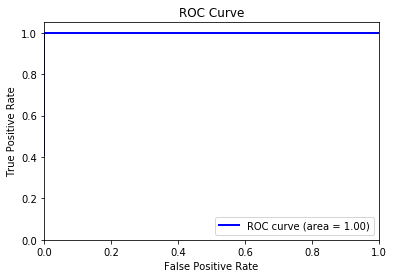

In [14]:
#Plot ROC for the entire test dataset
probs = logreg.predict_proba(test_data)
fpr, tpr, _ = roc_curve(test_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr,
         label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc),
         color='blue', linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('drebin.eps', format='eps', dpi=1000)
plt.show()


**THRESHOLDING FOR GREYBOX**

In [15]:
#Ratio of perturbed samples having cos sim greater
print ('FGSM:  %.4f' % ( comp_cos(cos_sim_fgsm, cos_sim_reg[fgsm_idx])))
print ('BIM-A:  %.4f' % ( comp_cos(cos_sim_bim_a, cos_sim_reg[bim_a_idx])))
print ('BIM-B:  %.4f' % ( comp_cos(cos_sim_bim_b, cos_sim_reg[bim_b_idx])))
print ('JSMA: %.4f' % ( comp_cos(cos_sim_jsma, cos_sim_reg[jsma_idx])))

FGSM:  0.0000
BIM-A:  0.0000
BIM-B:  0.0000
JSMA: 0.0000


In [16]:
#Ratio of perturbed samples having norm greater
print ('FGSM:  %.4f' % ( comp_norm(grads_fgsm_norms, grads_reg_norms[fgsm_idx])))
print ('BIM-A:  %.4f' % ( comp_norm(grads_bim_a_norms, grads_reg_norms[bim_a_idx])))
print ('BIM-B:  %.4f' % ( comp_norm(grads_bim_b_norms, grads_reg_norms[bim_b_idx])))
print ('JSMA: %.4f' % ( comp_norm(grads_jsma_norms, grads_reg_norms[jsma_idx])))

FGSM:  0.0000
BIM-A:  0.4400
BIM-B:  0.5067
JSMA: 0.4000


In [17]:
#Separate Using Cos Sim
eta = 0.75
print ('Regular: %.4f' % ( greater_cos(cos_sim_reg, eta)))
print ('FGSM:  %.4f' % ( greater_cos(cos_sim_fgsm, eta)))
print ('BIM-A:  %.4f' % ( greater_cos(cos_sim_bim_a, eta)))
print ('BIM-B:  %.4f' % ( greater_cos(cos_sim_bim_b, eta)))
print ('JSMA:  %.4f' % ( greater_cos(cos_sim_jsma, eta)))

Regular: 0.8700
FGSM:  0.0000
BIM-A:  0.0000
BIM-B:  0.1200
JSMA:  0.3700


In [18]:
#Separate using just norm
gamma = 29
print ('Regular: %.4f' % ( smaller_norm(grads_reg_norms, gamma)))
print ('FGSM:  %.4f' % ( smaller_norm(grads_fgsm_norms, gamma)))
print ('BIM-A:  %.4f' % ( smaller_norm(grads_bim_a_norms, gamma)))
print ('BIM-B:  %.4f' % ( smaller_norm(grads_bim_b_norms, gamma)))
print ('JSMA:  %.4f' % ( smaller_norm(grads_jsma_norms, gamma)))

Regular: 0.8100
FGSM:  1.0000
BIM-A:  1.0000
BIM-B:  0.9200
JSMA:  1.0000


In [19]:
#Use both cos and norm
print ('Regular: %.4f' % ( cos_and_norm_sep(cos_sim_reg, grads_reg_norms, eta, gamma)))
print ('FGSM:  %.4f' % ( cos_and_norm_sep(cos_sim_fgsm, grads_fgsm_norms, eta, gamma)))
print ('BIM-A:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_a, grads_bim_a_norms, eta, gamma)))
print ('BIM-B:  %.4f' % ( cos_and_norm_sep(cos_sim_bim_b, grads_bim_b_norms, eta, gamma)))
print ('JSMA:  %.4f' % ( cos_and_norm_sep(cos_sim_jsma, grads_jsma_norms, eta, gamma)))

Regular: 0.7800
FGSM:  0.0000
BIM-A:  0.0000
BIM-B:  0.0400
JSMA:  0.3700
